In [1]:
import pandas as pd
data_type = pd.read_csv('data_type.csv')

In [2]:
data_type.fillna('',inplace=True)

<br>

### Filter Out the Regular Returns and Regular Returns' Credit Back
I think it makes more sense to filter out the regular returns, as it will deem the analysis inaccurate, e.g. when you look at the increased sale of a discounted item, but that item is returned within the same transaction. It will look like the discount did not drive any sales, as the ultimate sale will be 0, unless you are looking only at the purchase entry for the discounted item while filtering out the return entry for this item.


In [103]:
data_type = data_type[(data_type.Type!='Regular_Return')&(data_type.Type!='CreditBack_RegularReturn')]

<br>

### Explore Each Feature Separetely

In [104]:
data_type.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,
3,A29,11-7270-00007-00057,41,1600.000,1.000,3/11/12 00:00,A1449,
4,A29,11-7270-00007-00057,42,1600.000,1.000,3/11/12 00:00,A1449,


In [105]:
print 'Shape of dataset: {0}'.format(data_type.shape)
print 'Number of unique stores: {0}'.format(len(data_type.StoreID.unique()))
print 'Number of unique transactions: {0}'.format(len(data_type.TransactionID.unique()))
print 'Number of unique lines: {0}'.format(len(data_type.Line.unique()))
print 'Number of unique dates: {0}'.format(len(data_type.Date.unique()))
print 'Number of unique SKUs: {0}'.format(len(data_type.SKU.unique()))

Shape of dataset: (1035563, 8)
Number of unique stores: 73
Number of unique transactions: 192963
Number of unique lines: 599
Number of unique dates: 2
Number of unique SKUs: 15179


In [106]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_type.describe()

,Line,Sales,Count
count,1035563.000,1035563.000,1035563.000
mean,10.774,1796.663,0.919
std,15.532,3470.922,1.086
min,1.000,-72233.000,0.000
25%,3.000,450.000,1.000
50%,7.000,1300.000,1.000
75%,14.000,2195.000,1.000
max,823.000,99995.000,120.000


- The records are organized on a SKU level by each transaction within each store, for each day.
- In each row, on average, the count will be 1 and sales will be 1800\$ for specific SKU bought in specific date within specific transaction and from specific store

<br>

### Total Sales and Total Count on Store Level

In [107]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [108]:
q = '''
    select
        StoreID, count(distinct TransactionID) as '# of transactions', count(distinct SKU) as '# of SKUs',
        sum(Sales) as 'Total Sales', sum(Count) as 'Total Count', sum(Sales)/count(distinct TransactionID) as 'Average Sales per Basket'
    from
        data_type
    group by
        StoreID
    '''
df1 = pysqldf(q)

In [109]:
df1.head()

,StoreID,# of transactions,# of SKUs,Total Sales,Total Count,Average Sales per Basket
0,A01,3442,2538,24136923.000,14537.000,7012.470
1,A02,1727,2402,20069356.998,8670.000,11620.936
2,A03,1759,2301,19175184.347,9067.000,10901.185
3,A05,2497,3018,24465311.295,12349.000,9797.882
4,A06,3513,2968,24951906.000,13152.000,7102.734


#### Description

In [110]:
df1.describe()

,# of transactions,# of SKUs,Total Sales,Total Count,Average Sales per Basket
count,73.000,73.000,73.000,73.000,73.000
mean,2643.329,2706.740,25487098.144,13035.397,9611.200
std,1156.019,806.736,11648972.356,6067.218,1891.669
min,84.000,22.000,355744.000,852.000,4235.048
25%,1759.000,2333.000,18743020.494,9067.000,8305.528
50%,2582.000,2754.000,24136923.000,12349.000,9797.882
75%,3440.000,3152.000,30911769.542,15718.000,11134.852
max,5978.000,4794.000,66352915.892,35470.000,13402.327


For each store, on average, there are 2600 transactions and 2700 unique SKUs will be sold. The average sales per basket is 9600$.

#### Distribution of SKUs across different stores

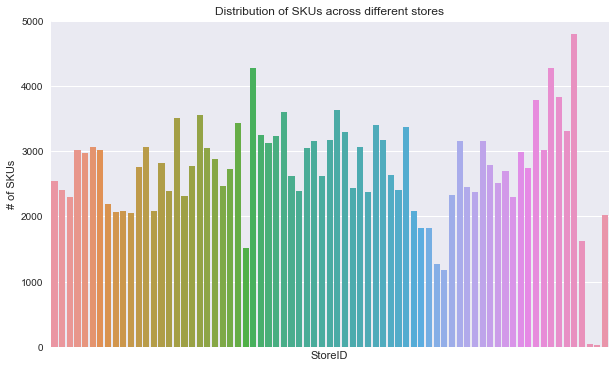

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
ax = sns.barplot(x='StoreID',y='# of SKUs',data=df1)
plt.ylabel('# of SKUs')
plt.ylim(0,5000)
plt.title('Distribution of SKUs across different stores')
plt.tick_params(axis='x',bottom='off',labelbottom='off')


#### Average Sales per Basket on Store Level

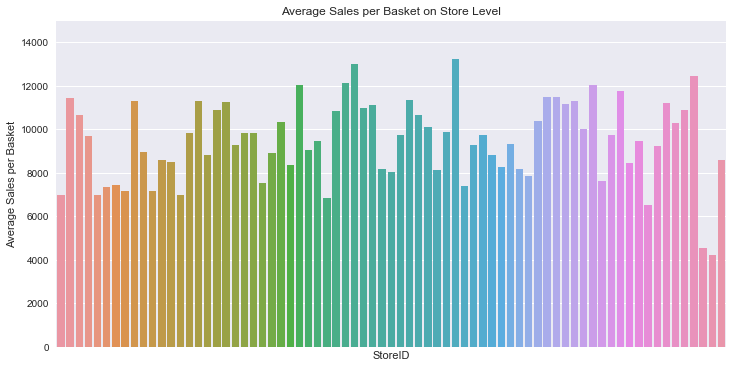

In [51]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='StoreID',y='Average Sales per Basket',data=df1)
plt.ylabel('Average Sales per Basket')
plt.ylim(0,15000)
plt.title('Average Sales per Basket on Store Level')
plt.tick_params(axis='x',bottom='off',labelbottom='off')

#### Abnormal Stores

In [112]:
df1[df1['# of SKUs']<1000]

,StoreID,# of transactions,# of SKUs,Total Sales,Total Count,Average Sales per Basket
70,A85,182,38,828255.000,1695.000,4550.852
71,A97,84,22,355744.000,852.000,4235.048


 Normally, in each store, it will sell 2500 unique SKUs on average and average sales per basket should around 10000\$. But for store A85 and A97, it only sold 38 and 22 unique SKUs, and average sales per basket is around 4500\$, which is abnoraml. We need investigaete these two stores and find out what happened.

<br><br>

### Total Sales and Total Count on SKU Level

In [150]:
q = '''
    select
        SKU, count(distinct StoreID) as 'Number_of_Stores', count(distinct TransactionID) as '# of transactions',
        sum(Sales) as 'Total Sales', sum(Count) as 'Total Count', sum(Sales)/sum(Count) as 'Unit Price',
        sum(Sales)/count(distinct TransactionID) as 'Average Sales per Basket For Specific SKU'
    from
        data_type
    group by
        SKU
    '''
df2 = pysqldf(q)

In [151]:
df2.head()

,SKU,Number_of_Stores,# of transactions,Total Sales,Total Count,Unit Price,Average Sales per Basket For Specific SKU
0,A1,26,68,94682.000,78.000,1213.872,1392.382
1,A10000,1,1,1995.000,1.000,1995.000,1995.000
2,A10001,1,3,5085.000,3.000,1695.000,1695.000
3,A10002,1,1,5000.000,1.000,5000.000,5000.000
4,A10003,11,21,57925.000,22.000,2632.955,2758.333


#### Description

In [152]:
df2.describe()

,Number_of_Stores,# of transactions,Total Sales,Total Count,Unit Price,Average Sales per Basket For Specific SKU
count,15179.000,15179.000,15179.000,15179.000,15179.000,15179.000
mean,13.017,45.379,122574.489,62.691,5700.351,6526.140
std,17.173,326.368,458896.215,529.021,7878.133,8786.995
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,2.000,2.000,9995.000,2.000,1700.000,2060.475
50%,5.000,6.000,32000.000,7.000,3000.000,3645.354
75%,18.000,26.000,94731.000,32.500,6895.000,7880.355
max,73.000,26190.000,19169707.400,35904.000,99995.000,169895.000


For specific SKU, on average, it wil be sold across 13 stores and 45 transactions. The average unit price for each SKU is 6500$/item.

#### Some Low-Price But Daily-Use Products

In [153]:
df2[df2['# of transactions']>5000]

,SKU,Number_of_Stores,# of transactions,Total Sales,Total Count,Unit Price,Average Sales per Basket For Specific SKU
7016,A20874,71,5528,4650030.000,9394.000,495.000,841.178
7604,A21771,64,18411,6812850.000,23658.000,287.972,370.042
9873,A25312,71,8516,8687450.000,13058.000,665.297,1020.133
10608,A2854,71,8413,7021800.000,15604.000,450.000,834.637
11106,A3664,62,26190,7820650.000,31171.000,250.895,298.612
12491,A5821,73,8187,1897500.000,12650.000,150.000,231.770


The specific product will be sold in 45 transactions across 13 stores on average. But some SKUs are pretty popular, they are sold in over 5000 transactions across over 60 stores. Their total sales are high and their unit price are low (median of unit price is 3000$), meaning that they are some **low-price but daily-use products**.

#### How many SKUs are sold by certian number of stores?

In [156]:
q = '''
    select
        Number_of_Stores, count(distinct SKU) as Number_of_SKUs
    from
        df2
    group by
        Number_of_Stores
    '''
df2_1 = pysqldf(q)

In [157]:
df2_1.head()

,Number_of_Stores,Number_of_SKUs
0,1,3702
1,2,1804
2,3,1171
3,4,841
4,5,617


In [158]:
df2_1.shape

(73, 2)

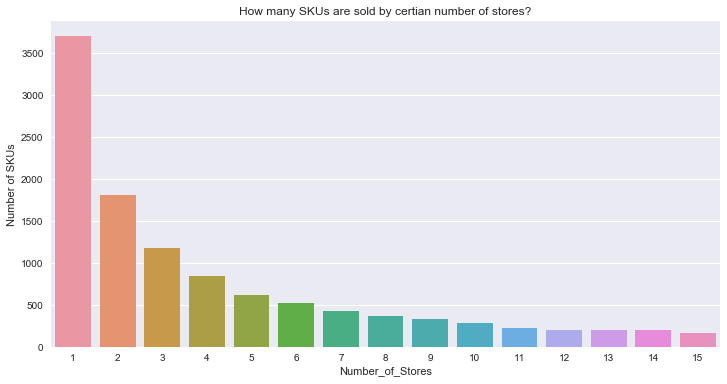

In [161]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Number_of_Stores',y='Number_of_SKUs',data=df2_1[:15])
plt.ylabel('Number of SKUs')
#plt.ylim(0,15000)
plt.title('How many SKUs are sold by certian number of stores?')
#plt.tick_params(axis='x',bottom='off',labelbottom='off')

#### How many stores have discounts for each SKU?

In [162]:
q='''
   select
       SKU, count(distinct StoreID) as 'Number of Stores With Discounted Items'
   from
       data_type
   where 
       Count=0
   group by 
       SKU
'''
df2_2=pysqldf(q)

In [163]:
df2_2.head()

,SKU,Number of Stores With Discounted Items
0,A1,8
1,A10004,1
2,A10022,3
3,A10045,12
4,A10048,4


In [166]:
df2_2.describe()

,Number of Stores With Discounted Items
count,3297.000
mean,11.621
std,15.571
min,1.000
25%,1.000
50%,4.000
75%,16.000
max,71.000


On average, there are 12 stores with discounted items for specific SKU.

#### Is Unit Price with 99900\$/item an outlier?

In [143]:
df2[df2['Unit Price']>90000]

,SKU,# of Stores,# of transactions,Total Sales,Total Count,Unit Price,Average Sales per Basket For Specific SKU
204,A10327,5,6,949000.000,10.000,94900.000,158166.667
1385,A12135,1,1,94900.000,1.000,94900.000,94900.000
5939,A19236,1,1,99900.000,1.000,99900.000,99900.000
6137,A19551,1,1,99995.000,1.000,99995.000,99995.000
7261,A21236,1,1,99900.000,1.000,99900.000,99900.000
7292,A21288,7,8,799200.000,8.000,99900.000,99900.000
11989,A5067,4,5,499500.000,5.000,99900.000,99900.000
13519,A7414,27,29,2997000.000,30.000,99900.000,103344.828


We can see there are several SKUs whose unit price is around 99900$/item, so we conclude that unit price with such high value may not be an outlier.

<br><br>

### Total Sales and Total Count on Transaction Level

In [121]:
q = '''
    select
        TransactionID, count(distinct SKU) as Number_of_SKUs,
        sum(Sales) as 'Total Sales', sum(Count) as 'Total Count', sum(Sales)/sum(Count) as 'Unit Price'
    from
        data_type
    group by
        TransactionID
    '''
df3 = pysqldf(q)

In [122]:
df3.head()

,TransactionID,Number_of_SKUs,Total Sales,Total Count,Unit Price
0,11-0160-00019-00003,1,3500.000,10.000,350.000
1,11-0160-00019-00007,2,5000.000,15.000,333.333
2,11-0160-00019-00008,2,5000.000,15.000,333.333
3,11-0160-00019-00010,2,5000.000,11.000,454.545
4,11-0160-00019-00011,3,7195.000,16.000,449.688


#### Description

In [123]:
df3.describe()

,Number_of_SKUs,Total Sales,Total Count,Unit Price
count,192963.000,192963.000,192963.000,192963.000
mean,3.570,9642.046,4.931,2566.671
std,3.567,12209.137,5.717,4278.149
min,1.000,0.150,1.000,0.002
25%,1.000,2500.000,1.000,1032.778
50%,2.000,5695.000,3.000,1600.000
75%,5.000,12256.000,6.000,2578.333
max,251.000,1011399.000,600.000,99900.000


Avearge number of unique SKUs in each transaction is 4, average total sales in each transaction 9600$, and average number of items bought in each transaction is 5.

In [131]:
df3[df3['Unit Price']<0.003]

,TransactionID,Number_of_SKUs,Total Sales,Total Count,Unit Price
29649,12-1803-00013-00363,1,0.150,72.000,0.002


In [125]:
df3[df3['Total Count']==600]

,TransactionID,Number_of_SKUs,Total Sales,Total Count,Unit Price
185051,12-7465-00017-00101,1,36000.000,600.000,60.000


In [124]:
df3[df3['Total Sales']==1011399]

,TransactionID,Number_of_SKUs,Total Sales,Total Count,Unit Price
188984,12-7681-00002-00002,132,1011399.000,150.000,6742.660


##### Distribution of Transactions Across Number of SKUs in Each Transaction

In [132]:
q = '''
    select
        Number_of_SKUs, count(distinct TransactionID) as Number_of_Transactions
    from
        df3
    group by
        Number_of_SKUs
    '''
df3_1 = pysqldf(q)

In [133]:
df3_1.head()

,Number_of_SKUs,Number_of_Transactions
0,1,69795
1,2,32736
2,3,21875
3,4,16501
4,5,12963


In [134]:
df3_1.shape

(53, 2)

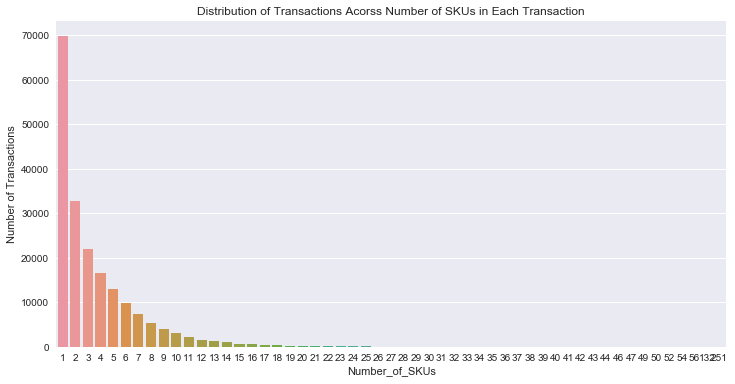

In [135]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Number_of_SKUs',y='Number_of_Transactions',data=df3_1)
plt.ylabel('Number of Transactions')
#plt.ylim(0,15000)
plt.title('Distribution of Transactions Acorss Number of SKUs in Each Transaction')
#plt.tick_params(axis='x',bottom='off',labelbottom='off')

Avearge number of unique SKUs in each transaction is 3.6. We can see from the plot, most of transactions concentrate on number of SKUs ranging from 1 to 10.

#### Transactions With Discounted Items VS Transactions Without Discounted Items

In [138]:
q='''
   select
       count(distinct TransactionID) as 'Number of Transactions With Discounted Items'
   from
       data_type
   where 
       Count=0
'''
df3_2=pysqldf(q)

In [141]:
df3_2['Number of Transactions Without Discounted Items'] = len(data_type.TransactionID.unique())- df3_2['Number of Transactions With Discounted Items']

df3_2

,Number of Transactions With Discounted Items,Number of Transactions Without Discounted Items
0,61078,131885
